# Imbalanced Classes, XGBoost, and Imputation - Homework Version

This is a copy of the guided task Notebook with most of the prose cut out so that you can focus on the code and the assignment questions.

## Class Imbalances


In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

hab_all = pd.read_csv("data/DNR_complete.csv")
hab_all.head()

,microcystin,x16s,mcy_a,doc_ppm,ortho_p_mg_p_l,tkn_mg_n_l,cl_mg_cl_l,p_h,tp,mcya_16s,HAB_next_week
0,0.000,1.946514e+07,0.0,3.899,0.0650,0.180,16.994,7.70,0.5380,0.0,0
1,0.000,4.278451e+06,0.0,4.689,0.0340,0.282,16.738,7.81,0.0570,0.0,0
2,0.230,6.102315e+05,0.0,3.886,0.0401,0.346,16.352,8.13,0.0961,0.0,0
3,0.743,5.582701e+06,0.0,3.824,0.0230,0.365,14.867,8.19,0.0180,0.0,0
4,0.038,1.010385e+07,0.0,2.248,0.0810,0.858,15.754,8.06,0.3680,0.0,0


In [2]:
hab_all.shape

(854, 11)

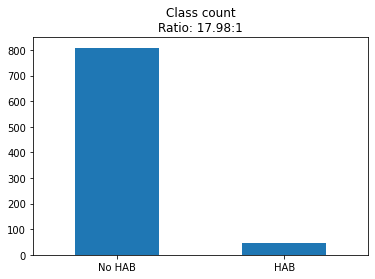

In [3]:
class_count = hab_all['HAB_next_week'].value_counts().rename({0: "No HAB", 1: "HAB"})

hab_class_ratio = class_count[0] / class_count[1]

class_count.plot(
    kind='bar', 
    title=f'Class count\nRatio: {hab_class_ratio:.2f}:1',
    rot=0
);
    

In [6]:
df = hab_all.dropna()

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop('HAB_next_week', axis=1)
y = df['HAB_next_week']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=489,
    stratify=y
)

### Homework questions 1

1. Why are class imbalances bad?
2. Why is accuracy a poor metric for prediction cases where there is a heavy class imbalance?
3. Stratifying on the target class is always important. Why is it especially important for cases with a heavy class imbalance? 
    * Hint: What's the worst-case scenario for the training-test split on an imbalanced data set?


In [11]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix

In [12]:
xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", seed=489)

xgb_classifier.fit(X_train, y_train, verbose=True, early_stopping_rounds=20,
                  eval_metric="auc", eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.74246
[1]	validation_0-auc:0.82708
[2]	validation_0-auc:0.83407
[3]	validation_0-auc:0.83370
[4]	validation_0-auc:0.83664
[5]	validation_0-auc:0.83664
[6]	validation_0-auc:0.83517
[7]	validation_0-auc:0.83002
[8]	validation_0-auc:0.83149
[9]	validation_0-auc:0.81898
[10]	validation_0-auc:0.85430
[11]	validation_0-auc:0.85578
[12]	validation_0-auc:0.84915
[13]	validation_0-auc:0.84547
[14]	validation_0-auc:0.84695
[15]	validation_0-auc:0.85136
[16]	validation_0-auc:0.86203
[17]	validation_0-auc:0.86461
[18]	validation_0-auc:0.84989
[19]	validation_0-auc:0.86902
[20]	validation_0-auc:0.85872
[21]	validation_0-auc:0.85357
[22]	validation_0-auc:0.85357
[23]	validation_0-auc:0.85725
[24]	validation_0-auc:0.84915
[25]	validation_0-auc:0.84474
[26]	validation_0-auc:0.85725
[27]	validation_0-auc:0.86461
[28]	validation_0-auc:0.85578
[29]	validation_0-auc:0.85725
[30]	validation_0-auc:0.86240
[31]	validation_0-auc:0.85725
[32]	validation_0-auc:0.85283
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=489,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=489,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [13]:
xgb_classifier.set_params(**{'n_estimators': xgb_classifier.best_ntree_limit})

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=73, n_jobs=4, num_parallel_tree=1, random_state=489,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=489,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

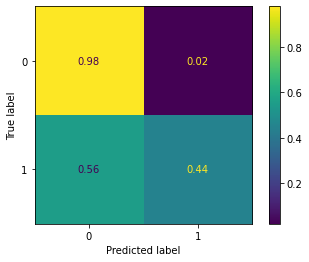

In [14]:
plot_confusion_matrix(
    xgb_classifier,
    X_test, y_test,
    normalize="true"
);

In [15]:
def get_roc_auc_score(classifier, X_test, y_test):
    y_pred = classifier.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred)

In [16]:
base_model_roc_auc = get_roc_auc_score(xgb_classifier, X_test, y_test)

print(f'ROC-AUC of base model: {base_model_roc_auc:.4f}')

ROC-AUC of base model: 0.8867


### Homework Questions 2

1. What does a confusion matrix tell us?
2. What would a perfect confusion matrix look like?
3. What is concerning about the above confusion matrix?
 

## The SMOTE Algorithm


In [17]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

xgb_classifier.fit(X_resampled, y_resampled, verbose=True, 
                   early_stopping_rounds=20,
                   eval_metric="auc", eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.85909
[1]	validation_0-auc:0.87270
[2]	validation_0-auc:0.88999
[3]	validation_0-auc:0.89735
[4]	validation_0-auc:0.89956
[5]	validation_0-auc:0.91170
[6]	validation_0-auc:0.90140
[7]	validation_0-auc:0.90250
[8]	validation_0-auc:0.89919
[9]	validation_0-auc:0.89330
[10]	validation_0-auc:0.89257
[11]	validation_0-auc:0.89919
[12]	validation_0-auc:0.89404
[13]	validation_0-auc:0.89404
[14]	validation_0-auc:0.88962
[15]	validation_0-auc:0.89551
[16]	validation_0-auc:0.89257
[17]	validation_0-auc:0.90140
[18]	validation_0-auc:0.90066
[19]	validation_0-auc:0.89551
[20]	validation_0-auc:0.88962
[21]	validation_0-auc:0.89036
[22]	validation_0-auc:0.88595
[23]	validation_0-auc:0.88447
[24]	validation_0-auc:0.88521


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=73, n_jobs=4, num_parallel_tree=1, random_state=489,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=489,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

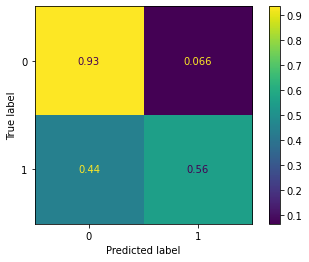

In [18]:
xgb_classifier.set_params(**{'n_estimators': xgb_classifier.best_ntree_limit})

plot_confusion_matrix(
    xgb_classifier,
    X_test, y_test,
    normalize="true"
)

In [28]:
smote_roc_auc = get_roc_auc_score(xgb_classifier, X_test, y_test)

print(f'ROC-AUC of SMOTE model: {smote_roc_auc:.4f}')

ROC-AUC of SMOTE model: 0.9117




### Homework Questions 3

1. What are some cases where undersampling is preferable to oversampling, and vice versa? 
2. Implement an Undersampling technique from the [`imbalanced-learn` library](https://imbalanced-learn.org/stable/user_guide.html#user-guide) and compare the results with those obtained from the SMOTE algorithm. 

## Imputation


In [20]:
X_imp = hab_all.drop('HAB_next_week', axis=1)
y_imp = hab_all['HAB_next_week']
X_imp_train, X_imp_test, y_imp_train, y_imp_test = train_test_split(
    X_imp, y_imp, test_size=0.20, random_state=489,
    stratify=y_imp
)

In [21]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

In [22]:
X_imp_train[:] = knn_imputer.fit_transform(X_imp_train)
X_imp_test[:] = knn_imputer.transform(X_imp_test)

In [23]:
xgb_imp_classifier = xgb.XGBClassifier(objective="binary:logistic", seed=489)

In [24]:
X_imp_resampled, y_imp_resampled = SMOTE().fit_resample(X_imp_train, y_imp_train)

In [25]:
xgb_imp_classifier.fit(X_imp_resampled, y_imp_resampled, verbose=True, 
                  eval_metric="auc", early_stopping_rounds=20,
                       eval_set=[(X_imp_test, y_imp_test)])

[0]	validation_0-auc:0.90946
[1]	validation_0-auc:0.91941
[2]	validation_0-auc:0.91941
[3]	validation_0-auc:0.92010
[4]	validation_0-auc:0.92284
[5]	validation_0-auc:0.91495
[6]	validation_0-auc:0.91667
[7]	validation_0-auc:0.91187
[8]	validation_0-auc:0.91187
[9]	validation_0-auc:0.90604
[10]	validation_0-auc:0.90398
[11]	validation_0-auc:0.91495
[12]	validation_0-auc:0.91427
[13]	validation_0-auc:0.91221
[14]	validation_0-auc:0.90741
[15]	validation_0-auc:0.90329
[16]	validation_0-auc:0.90535
[17]	validation_0-auc:0.90466
[18]	validation_0-auc:0.90466
[19]	validation_0-auc:0.90329
[20]	validation_0-auc:0.90604
[21]	validation_0-auc:0.90466
[22]	validation_0-auc:0.90329
[23]	validation_0-auc:0.90741
[24]	validation_0-auc:0.90672


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=489,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=489,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

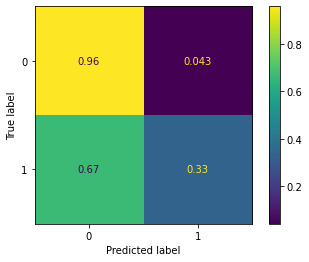

In [26]:
xgb_imp_classifier.set_params(**{'n_estimators': xgb_imp_classifier.best_ntree_limit})

plot_confusion_matrix(
    xgb_imp_classifier,
    X_imp_test, y_imp_test,
    normalize="true"
)

In [27]:
y_imp_pred = xgb_imp_classifier.predict_proba(X_imp_test)[:, 1]
roc_auc_score(y_imp_test, y_imp_pred)

0.9228395061728395



### Homework Questions 4

1. Implement another imputer from `sklearn.impute`. See the [sklearn docs](https://scikit-learn.org/stable/modules/impute.html) to learn more about imputation and to see other imputers.
2. Notice that we called `knn_impute.fit_transform` on the training set, but only called `.transform` on the testing set. Why is this important? 
    * Hint: Look up data leakage
3. Notice that while the ROC-AUC was bigger in the last version of our model, the [specificity (or true negative rate)](https://en.wikipedia.org/wiki/Sensitivity_and_specificity#Specificity) was lower. Between these two models, which one would you pick? Why?
4. Repeat this workflow on the abridged credit card fraud dataset located `../data/creditcard.csv`. This modified dataset has missing values and a class imbalance on the order of what we saw with the HAB dataset.